# Rusty Bargain machine learning model.
---
El servicio de venta de autos usados Rusty Bargain está desarrollando una aplicación para atraer nuevos clientes. Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. Tenemos el acceso al historial: especificaciones técnicas, versiones de equipamiento y precios. Nuestra meta es crear un modelo que determine el valor de mercado.

A Rusty Bargain le interesa:
- La calidad de la predicción.
- La velocidad de la predicción.
- El tiempo requerido para el entrenamiento.

## Preparación de datos

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor

In [2]:
df = pd.read_csv(r'C:\Users\luisP\Downloads\car_data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


### Análisis visual de los datos.
---
En esta sección entenderemos un poco los datos, veremos si existen patrones y tendencias, así como también valores atípicos. 

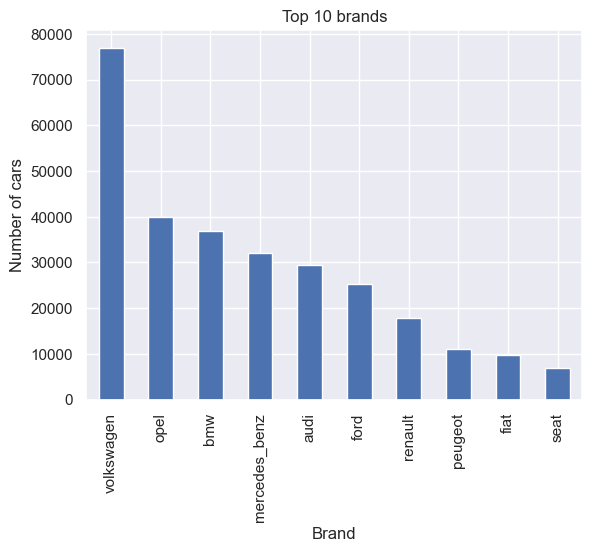

In [5]:
best_brands = df.groupby('Brand')['Brand'].count().sort_values(ascending=False).head(10)

best_brands.plot(kind="bar",x="Brand",
                            title="Top 10 brands",ylabel="Number of cars",xlabel="Brand")
plt.show()

<Axes: xlabel='RegistrationYear'>

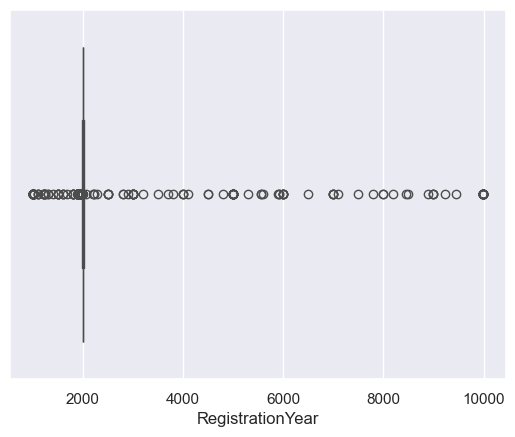

In [6]:
sns.boxplot(x=df['RegistrationYear'])

<Axes: xlabel='Power'>

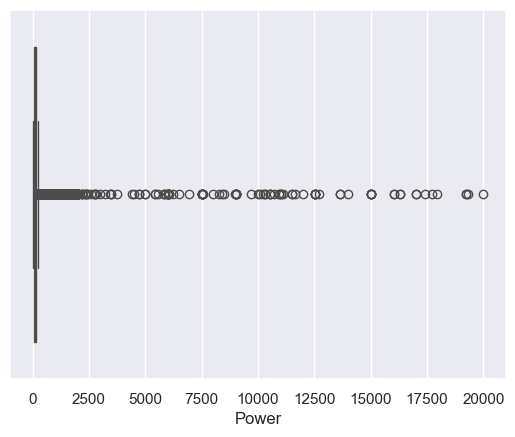

In [7]:
sns.boxplot(x=df['Power'])

Vemos que estamos ante un dataframe con bastantes valores atípicos. 

### Eliminación de columnas innecesarias.
---
Tenemos un dataset con muchos datos nulos y columnas que, en mi opinión, no aportan información relevante para determinar el precio final de un vehículo. Vamos a arreglarlo.

In [8]:
trash = ['DateCrawled', 'DateCreated', 'NumberOfPictures', 'LastSeen', 'PostalCode']

df = df.drop(trash, axis=1)
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


### Tratamiento para datos ausentes. 
---
Tenemos diferentes columnas con demasiados datos nulos, veo positivo que no fue ninguna variable numerica. Lo que yo considero adecuado seria sustituir los valores por 'Unknown'. Este valor seria codificado mas adelante. 

In [9]:
df.isna().sum()

Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Mileage                  0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
dtype: int64

In [10]:
df_1 = df.fillna('unknown')
df_1.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


### Codificación.
---
El método One-Hot es uno de los mas conocidos, pero en este proyecto me gustaría implementar una técnica diferente. Voy a sustituir el valor categórico por la frecuencia, es decir, el numero de veces que se repite.  La finalidad de esto es disminuir el numero de columnas que el método One-Hot crearía, lo que afectaría al rendimiento del modelo. 

In [11]:
cat_col = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

for cat in cat_col:
    df[cat] = df_1.groupby(cat)[cat].transform('count')
    
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,37490,1993,268251,0,29232,150000,0,216352,77013,71154
1,18300,16163,2011,268251,190,19705,125000,5,98720,29456,36054
2,9800,11996,2004,66285,163,561,125000,8,98720,677,71154
3,1500,79831,2001,268251,75,29232,150000,6,216352,77013,247161
4,3600,79831,2008,268251,69,2080,90000,7,98720,5500,247161


In [12]:
target = df['Price']
features = df.drop('Price', axis=1)

target.shape, features.shape

((354369,), (354369, 10))

 ### Escalado y estandarización de características.
 ---
Debido a las distintas frecuencias vemos que cada columna tiene su propio rango, esto podría confundir al modelo a la hora de entrenarlo, por ello vamos a estandarizar todas las características para prevenir que se asignen pesos y afecte nuestras predicciones. 

In [13]:
columns = features.columns
for col in features[columns]:
    minimo = features[col].min()
    maximo = features[col].max()
    print(f"{col}: minimo = {minimo}, maximo = {maximo}")

VehicleType: minimo = 3288, maximo = 91457
RegistrationYear: minimo = 1000, maximo = 9999
Gearbox: minimo = 19833, maximo = 268251
Power: minimo = 0, maximo = 20000
Model: minimo = 2, maximo = 29232
Mileage: minimo = 5000, maximo = 150000
RegistrationMonth: minimo = 0, maximo = 12
FuelType: minimo = 90, maximo = 216352
Brand: minimo = 225, maximo = 77013
NotRepaired: minimo = 36054, maximo = 247161


In [14]:
pd.options.mode.chained_assignment = None

scaler = StandardScaler()
scaler.fit(features[columns])

features[columns] = scaler.transform(features[columns])
features.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
0,-0.894770,-0.124512,0.563461,-0.579901,2.071540,0.574823,-1.533550,0.764998,1.662034,-1.373884
1,-1.667053,0.074983,0.563461,0.420888,1.050306,-0.084716,-0.191778,-0.913027,-0.200203,-1.778483
2,-1.817946,-0.002598,-1.638502,0.278671,-1.001809,-0.084716,0.613285,-0.913027,-1.327130,-1.373884
3,0.638460,-0.035848,0.563461,-0.184853,2.071540,0.574823,0.076576,0.764998,1.662034,0.654953
4,0.638460,0.041734,0.563461,-0.216457,-0.838982,-1.008070,0.344931,-0.913027,-1.138271,0.654953


### Creación de datasets para entrenamiento y validación. 
---
Vamos a separar los datos que utilizaremos para entrenar y validar los distintos modelos. Voy a aprovechar para convertir los datasets en matrices para que el proceso sea mas eficiente. 

In [15]:
features_train, sub_features, target_train, sub_target = train_test_split(
    features, target, test_size=0.40, random_state=12345)

features_valid, features_test, target_valid, target_test = train_test_split(
    sub_features, sub_target, test_size=0.50, random_state=12345)

X_train = np.array(features_train)
X_valid = np.array(features_valid)
X_test = np.array(features_test)

Y_train = np.array(target_train)
Y_valid = np.array(target_valid)
Y_test = np.array(target_test)

X_train.shape, X_valid.shape, X_test.shape

((212621, 10), (70874, 10), (70874, 10))

## Entrenamiento de modelos

### Modelo 1:  Linear Regression. 

In [16]:
%%time
model_1 = LinearRegression().fit(X_train, Y_train)
predictions = model_1.predict(X_valid)

error = mean_squared_error(Y_valid, predictions, squared=False)

print("RECM del modelo de regresión lineal con el conjunto de validación:", error)

RECM del modelo de regresión lineal con el conjunto de validación: 3811.6044780999255
CPU times: total: 172 ms
Wall time: 144 ms


c:\Users\luisP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Modelo 2: Random Forest Regressor.
---
Se muestra un modelo entrenado con bosque aleatorio de regresión, ya vienen ciertos hiperparámetros definidos, pero me gustaría agregar que busque la combinación que nos brindaba el mejor resultado, decidí no incluir el código completo ya que el entrenamiento tardaba demasiado. 

In [17]:
%%time
model_2 = RandomForestRegressor(random_state=54321, n_estimators=90, max_depth=10).fit(X_train, Y_train)
predictions = model_2.predict(X_valid)
        
error = mean_squared_error(Y_valid, predictions, squared=False)
print("RECM del modelo de bosque aleatorio de regresión con el conjunto de validación:", error)

RECM del modelo de bosque aleatorio de regresión con el conjunto de validación: 1978.5817022514525
CPU times: total: 34.1 s
Wall time: 1min 21s


c:\Users\luisP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Modelo 3: LightGBM.

In [18]:
%%time
model_3 = lgb.LGBMRegressor(metric='rmse')
model_3.fit(X_train, Y_train)

predictions = model_3.predict(X_valid)
        
error = mean_squared_error(Y_valid, predictions, squared=False)
print("RECM del modelo LightGBM con el conjunto de validación:", error)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005777 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 589
[LightGBM] [Info] Number of data points in the train set: 212621, number of used features: 10
[LightGBM] [Info] Start training from score 4414.475419
RECM del modelo LightGBM con el conjunto de validación: 1835.638632154425
CPU times: total: 6.27 s
Wall time: 1.66 s


c:\Users\luisP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Modelo 4: CatBoost.

In [19]:
#CÓDIGO PARA ENCONTRAR LOS MEJORES HIPERPARÁMETROS. 

#model = CatBoostRegressor()
#parameters = {'depth' : [6,8,10], 'learning_rate':[0.01, 0.05, 0.1], 'iterations':[30, 50, 100]}

#grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 2, n_jobs=-1)
#grid.fit(X_train, Y_train)

#print('Mejores parametros: ', grid.best_params_)

In [20]:
%%time
model_4 = CatBoostRegressor(iterations=200,
                            learning_rate=0.1,
                            depth=10,
                            loss_function='RMSE',
                            verbose=20)

model_4.fit(X_train, Y_train)

predictions = model_4.predict(X_valid)
        
error = mean_squared_error(Y_valid, predictions, squared=False)
print("RECM del modelo CatBoost con el conjunto de validación:", error)

0:	learn: 4203.1988535	total: 227ms	remaining: 45.2s
20:	learn: 2158.3866813	total: 1.62s	remaining: 13.8s
40:	learn: 1954.2037092	total: 3s	remaining: 11.6s
60:	learn: 1880.8594391	total: 4.42s	remaining: 10.1s
80:	learn: 1835.7198029	total: 5.78s	remaining: 8.49s
100:	learn: 1806.2090576	total: 7.13s	remaining: 6.99s
120:	learn: 1777.8625812	total: 8.5s	remaining: 5.55s
140:	learn: 1751.4141146	total: 9.86s	remaining: 4.13s
160:	learn: 1731.1723045	total: 11.2s	remaining: 2.72s
180:	learn: 1711.6808654	total: 12.6s	remaining: 1.32s
199:	learn: 1697.3166970	total: 13.9s	remaining: 0us
RECM del modelo CatBoost con el conjunto de validación: 1776.8852775217829
CPU times: total: 18.6 s
Wall time: 14.3 s


c:\Users\luisP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Análisis de los modelos.

Se realizaron 4 modelos y diversas mejoras/correcciones, en base a los resultados se obtuvieron los siguientes conclusiones:

•	Si bien Linear Regression fue el modelo más rápido, su RECM fue el mas alto y por bastante.

•	El modelo CatBoost nos dio el mejor resultado, y después de entrenarlo con los datos en forma de matrices el tiempo de entrenamiento se redujo significativamente. Sin duda el mejor.

•	Para poder seleccionar los mejores hiperparámetros del modelo Random Forest Reggressor, tuvimos que hacer uso de un bucle for que tardo una exageración para al final darnos un RECM algo elevado. No lo recomendaría. 

•	En lo personal, me quedaría con el modelo de LightGBM, ya que su entrenamiento fue bastante rápido y el error fue bajo. Me gustaría agregar que no utilice un conjunto de hiperparámetros, pero estoy seguro que de haber agregado algunos, el RECM hubiera sido mayor. 


### Prueba del mejor modelo.
---
Ya que hicimos la comparativa y determinamos el mejor algoritmo, vamos a ver el resultado que obtenemos con el dataset de prueba.

In [21]:
%%time
test_predictions = model_4.predict(X_test)
        
error = mean_squared_error(Y_test, test_predictions, squared=False)
print("RECM del modelo CatBoost con el conjunto de prueba:", error)

RECM del modelo CatBoost con el conjunto de prueba: 1791.822897943184
CPU times: total: 328 ms
Wall time: 73.3 ms


c:\Users\luisP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Muy buen error de prediccion y excelente el tiempo de respuesta. Sin duda el mejor.

In [22]:
df['Price'].describe()

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

# Conclusión final.
---
En nuestro mejor modelo obtuvimos un RMSE de $1,791 USD, valor considerable ya que en promedio el valor de los autos es de $4,417 USD, se puede interpretar que el error estándar es aproximadamente el 40.5% del promedio de pedidos. Este es un valor considerable y no creo que pueda ser considerado aceptable por el contexto y los objetivos del negocio. Tratamos con un dataset con bastantes datos nulos e inconsistentes. La propuesta para mejorar el resultado sería trabajar en pulir la información proporcionada y buscar la manera de completar los valores ausentes.